In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack

# Importing the potential landscape file

In [9]:
x,y= np.loadtxt("potential_landscape.txt", delimiter = '\t', unpack=True)

In [10]:
def gate_well_potential(position,potential):
    
    # Position where the gate well starts.
    gate_well_start_index = -3.5
    # Position where the gate well ends.
    gate_well_end_index   = 2.8
    # Extracts the gate well position.
    well_position = position[np.where((position > gate_well_start_index) & (position < gate_well_end_index))]
    # Extract the corresponding potential values for the gate well.
    well_potential = potential[np.where(position == well_position[0])[0][0]:np.where(position == well_position[-1])[0][0]+1]
    
    return [well_position,well_potential]

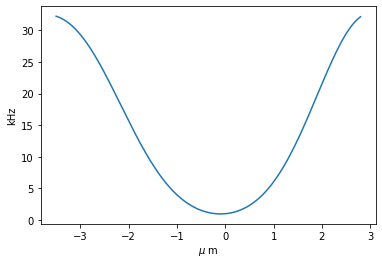

In [11]:
plt.plot(gate_well_potential(x,y)[0],gate_well_potential(x,y)[1])
plt.xlabel(r"$\mu$ m")
plt.ylabel(r"kHz")
plt.show()

In [12]:
# Constants.
PI    = np.pi
H_BAR = 1.0545*10**(-34) # m^2 kg/s

In [13]:
r""" Rb87 parameters """
M   = 1.4192261*10**(-25) # kg
a_s = 98.006*5.29*10**(-11) # m https://journals.aps.org/pra/abstract/10.1103/PhysRevA.87.053614
g   = (4*PI*H_BAR**2*a_s)/M

external_potential = gate_well_potential(x,y)[1]*(10**3)*(H_BAR) # J

def V_external(x):
    return external_potential

# H(k)
def Hamiltonian_k(p):
    return p**2/(2*M)

# H(x).
def Hamiltonian_x(x,psi):
    return V_external(x)+g*np.abs(psi)**2

# Time evolution

$$ \exp{(-i(H(k)+H(x)) dt)} = e^{-iH(k)dt/2} \quad e^{-iH(x)dt} \quad e^{-iH(k)dt/2} $$

In [14]:
x_minimum = -3.5
x_maximum = 2.8

# Space will be divided into N parts.
N = len(gate_well_potential(x,y)[0])

r""" Energy """
# Discretization of the momentum space.
dk = 2*PI/(x_maximum-x_minimum)
k = np.hstack([np.arange(0,N/2), np.arange(-N/2,0)])*dk
E_k = (H_BAR**2*k**2)/(2*M)

# Increment in time.
dt = 1.e-10

r""" Position """
xs = np.linspace(x_minimum,x_maximum,N)*(10**(-6)) # m

OMEGA = 1
# Initial guess.
psi_initial = (((M*OMEGA/(PI*H_BAR)))**(1/4))*np.exp(-(M*OMEGA/(2*H_BAR))*xs**2) #(1/np.sqrt(N))*np.ones(N)
psi_initial = psi_initial/np.linalg.norm(psi_initial)    

def imaginary_time_evolution(initial_guess, iteration):
        
    psi_x = initial_guess
    # Wavefunction is transformed into momentum basis.
    psi_k = fftpack.fft(psi_x)
    
    for i in range(iteration):
        
        # exp(-i H(k) * dt/(2*h_bar) * psi_k.
        psi_k = np.exp(-(E_k * dt)/(2*H_BAR)) * psi_k


        # Wavefunction is transformed into position basis.
        psi_x = fftpack.ifft(psi_k)
        # exp(-i H(x) * dt/h_bar) * psi_x.
        psi_x = np.exp(-(Hamiltonian_x(xs,psi_x) * dt)/H_BAR) * psi_x


        # Wavefunction is transformed into momentum basis.
        psi_k = fftpack.fft(psi_x)
        # exp(-i H(k) * dt/(2*h_bar) * psi_k.
        psi_k = np.exp(-(E_k * dt)/(2*H_BAR)) * psi_k

        
        psi_x = fftpack.ifft(psi_k)
        # Wavefunction is normalized.
        psi_x = psi_x/np.linalg.norm(psi_x)
  
        psi_k = fftpack.fft(psi_x)
    
    psi_x = fftpack.ifft(psi_k)
    return psi_x/np.linalg.norm(psi_x)

In [15]:
psi_imaginary_time_evolved = imaginary_time_evolution(psi_initial,100000)

In [20]:
# The exact ground state of a quantum harmonic oscillator.
def psi_0(x):
    return (((M*OMEGA/(PI*H_BAR)))**(1/4))*np.exp(-(M*OMEGA/(2*H_BAR))*x**2)

# Plot

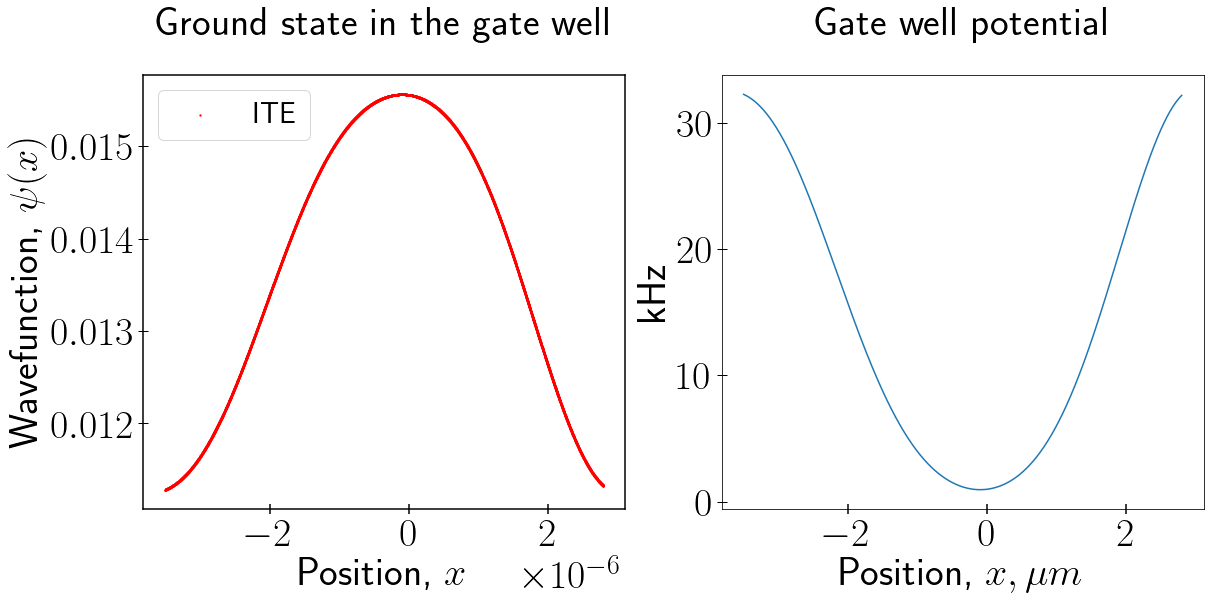

In [21]:
large = 40; med = 30; small = 20
params = {'axes.titlesize': large,
          'axes.titlepad' : large,
          'legend.fontsize': med,
          'axes.labelsize': large ,
          'axes.titlesize': large ,
          'xtick.labelsize': large ,
          'ytick.labelsize': large ,
          'figure.titlesize': large}
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'
plt.rcParams.update(params)
f = plt.figure()
plt.figure(1)

plt.subplot(121)
plt.scatter(xs,psi_imaginary_time_evolved.real,s=1.5,color='red',label="ITE")
plt.legend()
plt.title('Exact wavefunction')
plt.xlabel("Position, "+r"$x$",fontweight='bold')  # Set X-axis label
plt.xticks(fontweight='bold')
plt.ylabel("Wavefunction, "+r"$\psi(x)$",fontweight='bold')  # Set Y-axis label
plt.yticks(fontweight='bold')
ax = f.gca()
ax.tick_params(axis="x", direction="inout", length=10, width=1.5, color="k")
ax.tick_params(axis="y", direction="inout", length=10, width=1, color="k")
plt.title('Ground state in the gate well')
#plt.grid(linestyle='--', alpha=0.5)
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    
plt.subplot(122)
plt.plot(gate_well_potential(x,y)[0],gate_well_potential(x,y)[1],linewidth = 1.5)
plt.xlabel("Position, "+r"$x ,\mu m $",fontweight='bold')  # Set X-axis label
plt.ylabel(r"kHz")
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.title('Gate well potential')
ax = f.gca()
ax.tick_params(axis="x", direction="inout", length=10, width=1.5, color="k")
ax.tick_params(axis="y", direction="inout", length=10, width=1, color="k")
f.set_figwidth(19)
f.set_figheight(8)
plt.show()